In [1]:
import os
import tarfile
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import scipy
import gc

In [2]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/GSE212252"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/GSE212252


In [3]:
# Define the paths for all datasets
data_paths = [
    './DATA/EMBRYO_CRE_NEGATIVE',
    './DATA/EMBRYO_CRE_POSITIVE',
    './DATA/POST_NATAL_CRE_NEGATIVE',
    './DATA/POST_NATAL_CRE_POSITIVE'
]

# Load all datasets
adatas = []
for path in data_paths:
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    # Add a column to identify the origin of each cell
    adata.obs['origin'] = os.path.basename(path)
    adatas.append(adata)

# Combine all datasets
adata_combined = ad.concat(adatas, join='outer', merge='same', label='origin')

# Clean up to free memory
del adatas
gc.collect()

# The combined dataset is now in adata_combined
adata = adata_combined

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata

AnnData object with n_obs × n_vars = 2933639 × 32286
    obs: 'origin'
    var: 'gene_ids', 'feature_types'

In [6]:
adata.obs.head()

,origin
AAACAGCCAAACAACA-1,0
AAACAGCCAAACATAG-1,0
AAACAGCCAAACCCTA-1,0
AAACAGCCAAACCTAT-1,0
AAACAGCCAAACCTTG-1,0


In [7]:
adata.obs.origin.value_counts()

origin
0    736217
2    736156
3    736108
1    725158
Name: count, dtype: int64

In [8]:
adata.X

<2933639x32286 sparse matrix of type '<class 'numpy.float32'>'
	with 169823478 stored elements in Compressed Sparse Row format>

In [9]:
non_zero_elements = adata.X.data[:10] if scipy.sparse.issparse(adata.X) else adata.X[np.nonzero(adata.X)][:10]

print("First 10 non-zero elements of adata.X:")
print(non_zero_elements)

First 10 non-zero elements of adata.X:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

In [12]:
adata.var.head()

,gene_ids,feature_types,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,ENSMUSG00000051951,Gene Expression,19398,False,19398,0.476063,0.389378,88.915429,83311.0,11.330348
Gm1992,ENSMUSG00000089699,Gene Expression,1246,False,1246,0.008183,0.008150,99.288000,1432.0,7.267526
Gm19938,ENSMUSG00000102331,Gene Expression,3914,False,3914,0.028680,0.028276,97.763429,5019.0,8.521185
Gm37381,ENSMUSG00000102343,Gene Expression,48,False,48,0.000474,0.000474,99.972571,83.0,4.430817
Rp1,ENSMUSG00000025900,Gene Expression,1092,False,1092,0.012451,0.012375,99.376000,2179.0,7.687080


In [13]:
gc.collect()

20

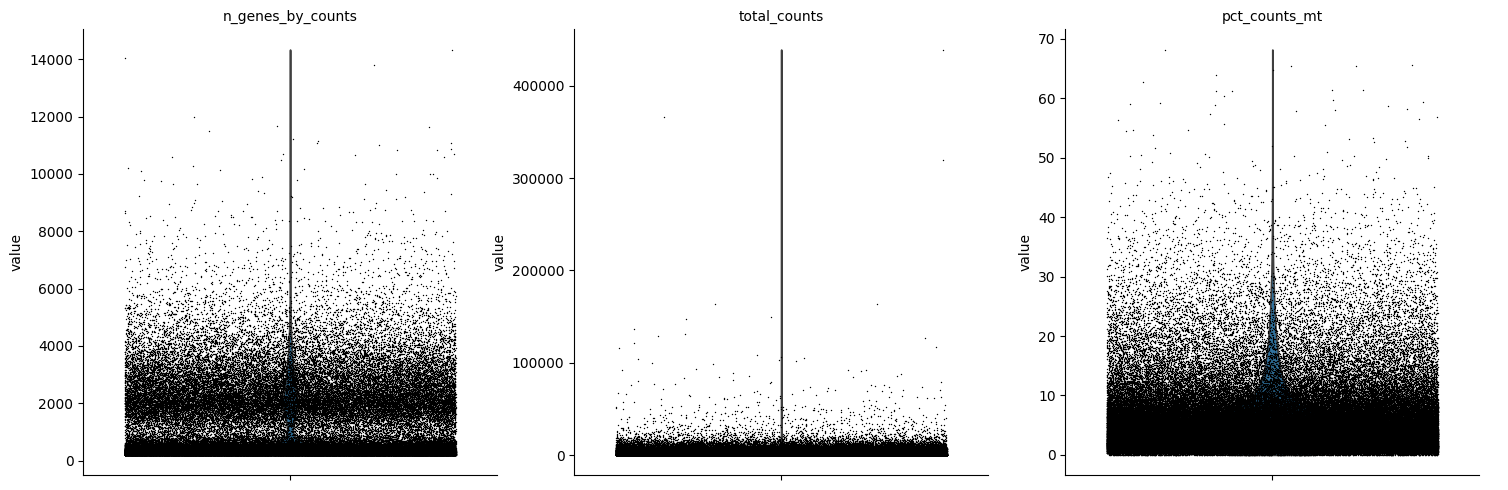

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.total_counts < 10000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
gc.collect()

501

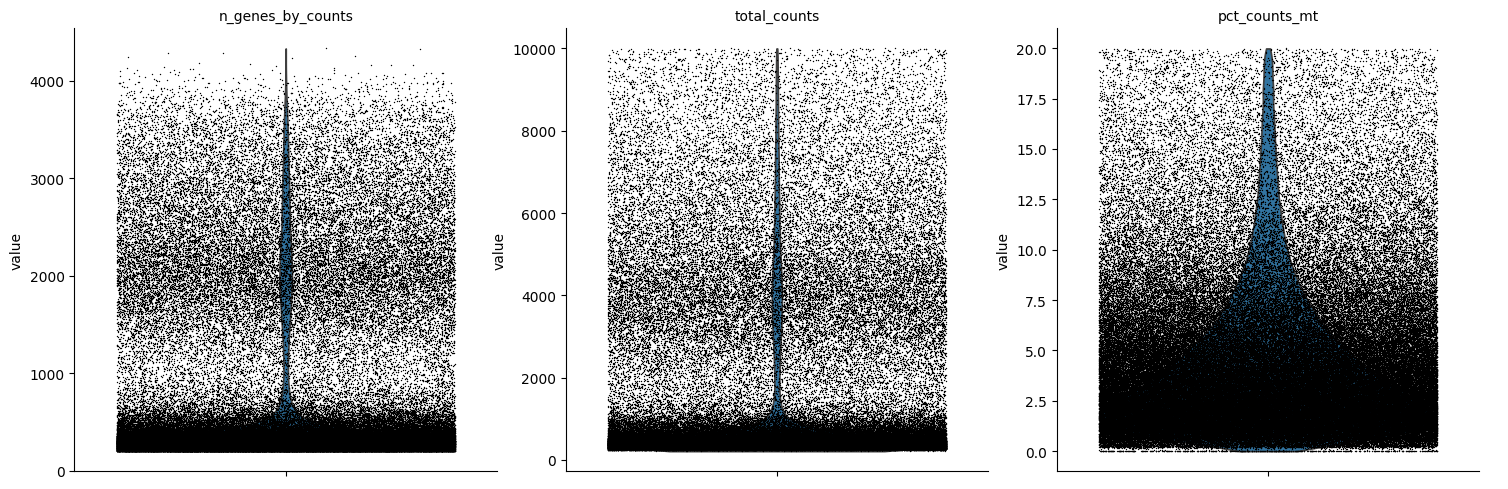

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [19]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


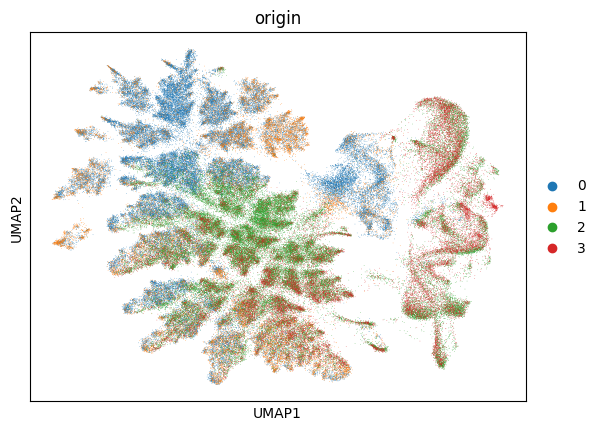

In [23]:
sc.pl.umap(adata, color=['origin'], wspace=0.4)


In [ ]:
adata.write('./output/processed_combined_data_from_raw.h5ad')

In [21]:
# # Save as Seurat object
# import anndata2ri
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr

# # Activate automatic conversion between AnnData and SingleCellExperiment
# anndata2ri.activate()

# # Import necessary R packages
# seurat = importr('Seurat')
# base = importr('base')

# # Convert AnnData to SingleCellExperiment
# sce = anndata2ri.py2rpy(adata)

# # Create Seurat object
# seurat_obj = seurat.CreateSeuratObject(counts=sce.slots['assays'].slots['X'],
#                                        meta_data=sce.slots['colData'])

# # Save Seurat object
# base.saveRDS(seurat_obj, "./output/processed_combined_data_from_raw.rds")

# # To load this Seurat object in R using rpy2, you can use the following code:
# # (This part is just for demonstration, it won't actually run in the Python environment)

# '''
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr

# # Import necessary R packages
# base = importr('base')
# seurat = importr('Seurat')

# # Load the Seurat object
# seurat_obj = base.readRDS("./output/processed_combined_data_from_raw.rds")

# # Now you can use the Seurat object in your R environment via rpy2
# '''
